In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install torch torchvision torchaudio
!pip install pycocotools


In [ ]:
import os
import zipfile

# Unzip the dataset
zip_path = '/content/drive/MyDrive/smartdiagnosisofclothflaw_round1train2_datasets.zip'
extract_path = '/content/'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Define paths
dataset_path = os.path.join(extract_path, 'guangdong1_round1_train2_20190828')
defect_images_path = os.path.join(dataset_path, 'defect_Images')
normal_images_path = os.path.join(dataset_path, 'normal_Images')
annotations_path = os.path.join(dataset_path, 'Annotations', 'anno_train.json')


In [ ]:
import json
from sklearn.model_selection import train_test_split
import pandas as pd

# Load annotations
with open(annotations_path, 'r', encoding='utf-8') as f:
    annotations = json.load(f)

# Parse annotations to create a DataFrame
data = []
for annotation in annotations:
    img_name = annotation['name']
    bbox = annotation['bbox']
    defect_name = annotation['defect_name']
    data.append([img_name, defect_name, bbox])

df = pd.DataFrame(data, columns=['image', 'defect_name', 'bbox'])

# Split into train and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as T

class FabricDataset(Dataset):
    def __init__(self, df, image_dir, transform=None):
        self.df = df
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        record = self.df.iloc[idx]
        img_name = record['image']
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert("RGB")

        boxes = torch.tensor(record['bbox']).unsqueeze(0)
        labels = torch.tensor([1])  # 1 for defect, assuming 0 would be normal

        target = {
            'boxes': boxes,
            'labels': labels
        }

        if self.transform:
            image = self.transform(image)

        return image, target

# Define transformations
transform = T.Compose([
    T.ToTensor()
])

# Create Datasets and DataLoaders
train_dataset = FabricDataset(train_df, defect_images_path, transform=transform)
val_dataset = FabricDataset(val_df, defect_images_path, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))


In [ ]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# Load a pre-trained model and replace the classifier with a new one
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# Modify the classifier head for the new dataset (2 classes: background, defect)
num_classes = 2  # Background and defect
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

# Move model to GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 154MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
import torch.optim as optim
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Initialize the optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# Training loop
num_epochs = 3

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for images, targets in train_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        train_loss += losses.item()

    print(f"Epoch {epoch+1}, Loss: {train_loss/len(train_loader)}")


Epoch 1, Loss: 0.37354967496189234
Epoch 2, Loss: 0.2710286703863516
Epoch 3, Loss: 0.24286623124790724


In [ ]:
# Specify the additional number of epochs
additional_epochs = 3

# Continue training loop for additional epochs
for epoch in range(3, 3 + additional_epochs):
    model.train()
    train_loss = 0
    for images, targets in train_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # Backpropagation
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        train_loss += losses.item()

    print(f"Epoch {epoch+1}, Loss: {train_loss/len(train_loader)}")


Epoch 4, Loss: 0.22092551605200036
Epoch 5, Loss: 0.1978605575133167
Epoch 6, Loss: 0.1849885786310212


In [ ]:
# Specify the additional number of epochs
further_epochs = 3

# Continue training loop for further epochs
for epoch in range(6, 6 + further_epochs):
    model.train()
    train_loss = 0
    for images, targets in train_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # Backpropagation
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        train_loss += losses.item()

    print(f"Epoch {epoch+1}, Loss: {train_loss/len(train_loader)}")


Epoch 7, Loss: 0.17163581459220073
Epoch 8, Loss: 0.15996875961552423
Epoch 9, Loss: 0.15601778063601437


In [ ]:
# Specify to run for the final 10th epoch
final_epoch = 1

# Continue training loop for the 10th epoch
for epoch in range(9, 9 + final_epoch):
    model.train()
    train_loss = 0
    for images, targets in train_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # Backpropagation
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        train_loss += losses.item()

    print(f"Epoch {epoch+1}, Loss: {train_loss/len(train_loader)}")


Epoch 10, Loss: 0.14634620182444458


In [ ]:
pip install scikit-learn matplotlib


In [ ]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Set model to evaluation mode
model.eval()

all_preds = []
all_labels = []

# Disable gradient computation for evaluation
with torch.no_grad():
    for images, targets in val_loader:
        images = list(image.to(device) for image in images)
        outputs = model(images)  # Get predictions

        for i, output in enumerate(outputs):
            pred_scores = output['scores'].cpu().numpy()
            pred_labels = output['labels'].cpu().numpy()

            # Assuming binary classification: defect ('1') vs no defect ('0')
            threshold = 0.5  # Adjust threshold as necessary
            pred_labels_binary = (pred_scores > threshold).astype(int)

            # Get true labels for each image
            true_labels = targets[i]['labels'].cpu().numpy()
            true_labels_binary = (true_labels > 0).astype(int)

            # Extend predictions and true labels lists with the binary values
            all_preds.extend(pred_labels_binary)
            all_labels.extend(true_labels_binary)

# Convert lists to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Ensure both arrays have the same length
if len(all_preds) != len(all_labels):
    print(f"Predictions and labels length mismatch: {len(all_preds)} != {len(all_labels)}")
    # Check lengths to debug
    print(f"Number of predictions: {len(all_preds)}, Number of true labels: {len(all_labels)}")
else:
    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Defect', 'Defect'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix for Fabric Defect Detection')
    plt.show()


Predictions and labels length mismatch: 2080 != 359
Number of predictions: 2080, Number of true labels: 359


In [ ]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Set model to evaluation mode
model.eval()

all_preds = []
all_labels = []

# Disable gradient computation for evaluation
with torch.no_grad():
    for images, targets in val_loader:
        images = list(image.to(device) for image in images)
        outputs = model(images)  # Get predictions

        for i, output in enumerate(outputs):
            pred_boxes = output['boxes'].cpu().numpy()
            pred_scores = output['scores'].cpu().numpy()
            pred_labels = output['labels'].cpu().numpy()

            # Assuming that the defect class is represented by '1' and normal is '0'
            threshold = 0.5  # Adjust threshold as necessary
            pred_labels_binary = (pred_scores > threshold).astype(int)

            true_labels = targets[i]['labels'].cpu().numpy()
            true_labels_binary = (true_labels > 0).astype(int)

            # Combine all predicted and true labels for this image
            all_preds.extend(pred_labels_binary)
            all_labels.extend(true_labels_binary)

# Post-process to handle varying numbers of predictions per image
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Ensure both arrays have the same length
if len(all_preds) != len(all_labels):
    print(f"Predictions and labels length mismatch: {len(all_preds)} != {len(all_labels)}")
    print(f"Number of predictions: {len(all_preds)}, Number of true labels: {len(all_labels)}")
else:
    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Defect', 'Defect'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix for Fabric Defect Detection')
    plt.show()


Predictions and labels length mismatch: 2080 != 359
Number of predictions: 2080, Number of true labels: 359


In [ ]:
# Specify the path to save the model and optimizer state
save_path = 'fasterrcnn_fabric_defect_detection_full_training.pth'

# Save the model and optimizer state
torch.save({
    'epoch': 10,  # The last completed epoch
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss': train_loss,  # Last recorded training loss
    'val_loss': val_loss,  # Last recorded validation loss
}, save_path)

print(f"Model and training state saved to {save_path}")


Model and training state saved to fasterrcnn_fabric_defect_detection_full_training.pth


In [ ]:
import torch
import numpy as np
from sklearn.metrics import precision_recall_fscore_support

# Set model to evaluation mode
model.eval()

all_preds = []
all_labels = []

# Disable gradient computation for evaluation
with torch.no_grad():
    for images, targets in val_loader:
        images = list(image.to(device) for image in images)
        outputs = model(images)  # Get predictions

        for i, output in enumerate(outputs):
            pred_boxes = output['boxes'].cpu().numpy()
            pred_scores = output['scores'].cpu().numpy()
            pred_labels = output['labels'].cpu().numpy()

            # Convert predictions to binary based on a threshold
            threshold = 0.5
            pred_labels_binary = (pred_scores > threshold).astype(int)

            true_labels = targets[i]['labels'].cpu().numpy()
            true_labels_binary = (true_labels > 0).astype(int)

            # Aggregate predictions and true labels for each image
            all_preds.extend(pred_labels_binary)
            all_labels.extend(true_labels_binary)

# Convert lists to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Ensure both arrays have the same length
if len(all_preds) != len(all_labels):
    print(f"Predictions and labels length mismatch: {len(all_preds)} != {len(all_labels)}")
    print(f"Number of predictions: {len(all_preds)}, Number of true labels: {len(all_labels)}")
else:
    # Calculate precision, recall, and F1 score
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary')

    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')


Predictions and labels length mismatch: 2080 != 359
Number of predictions: 2080, Number of true labels: 359


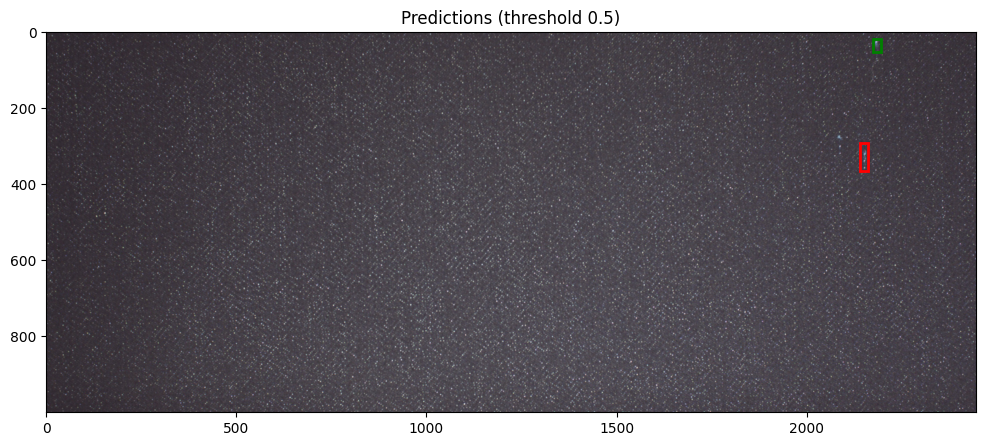

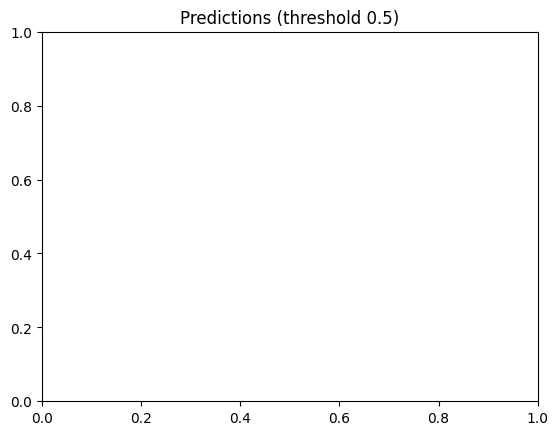

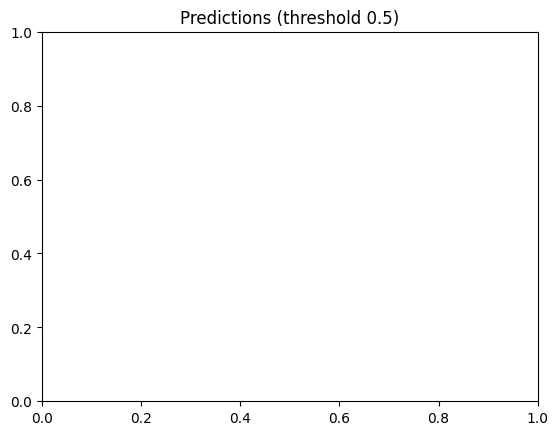

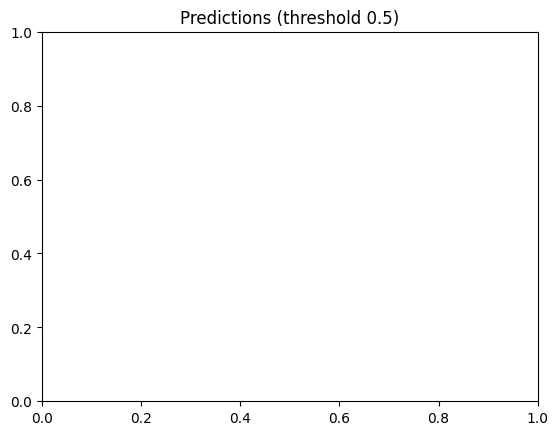

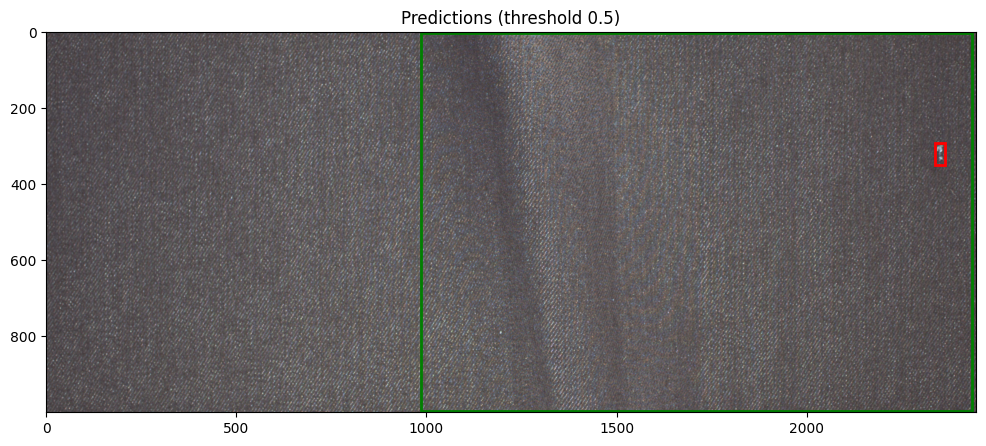

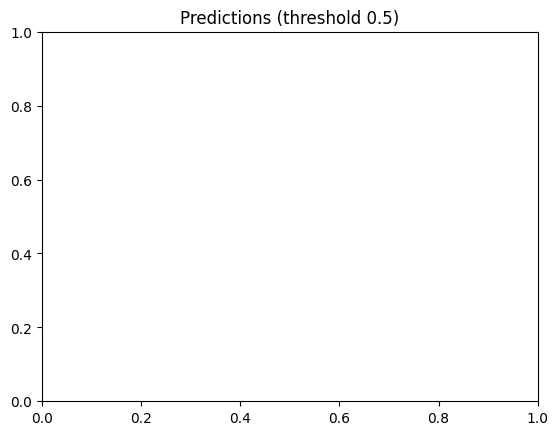

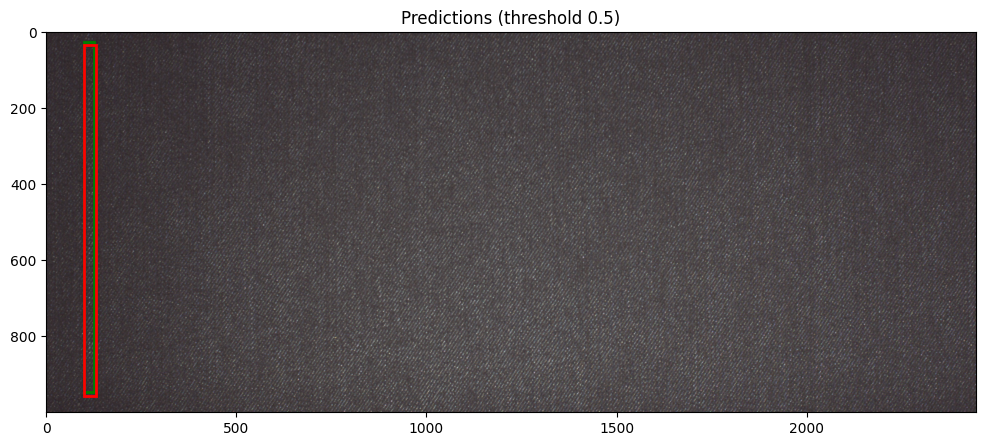

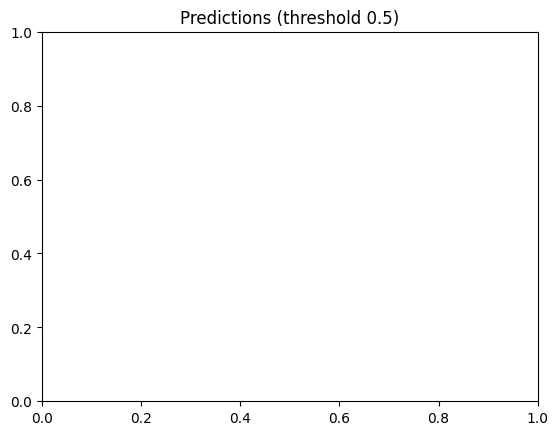

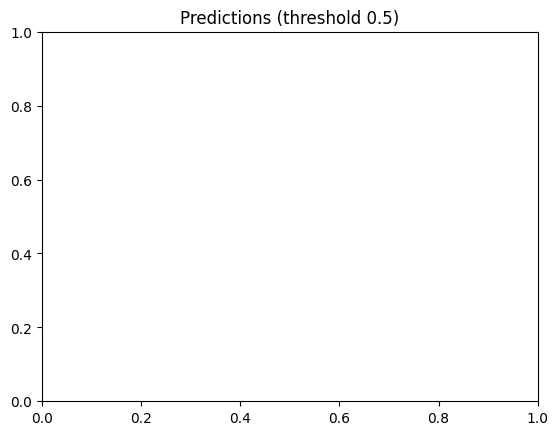

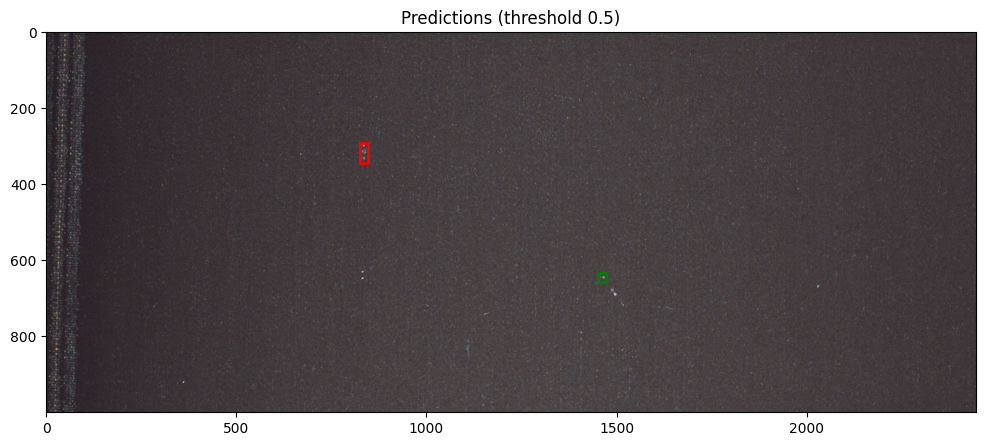

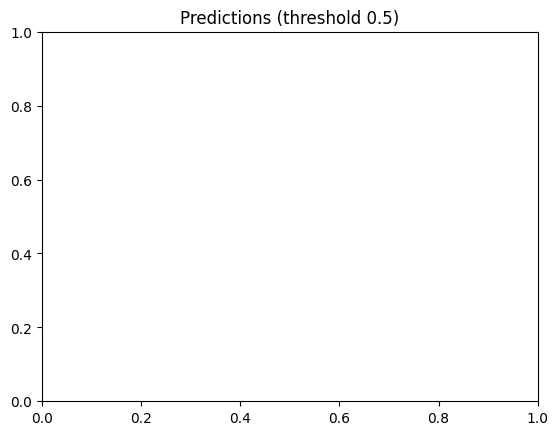

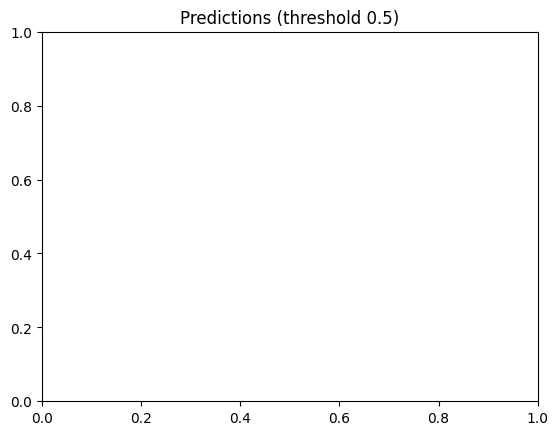

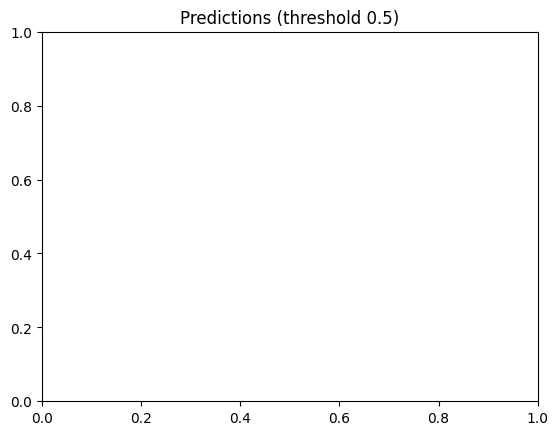

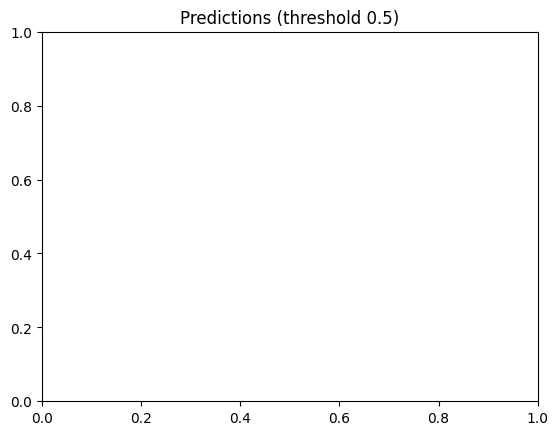

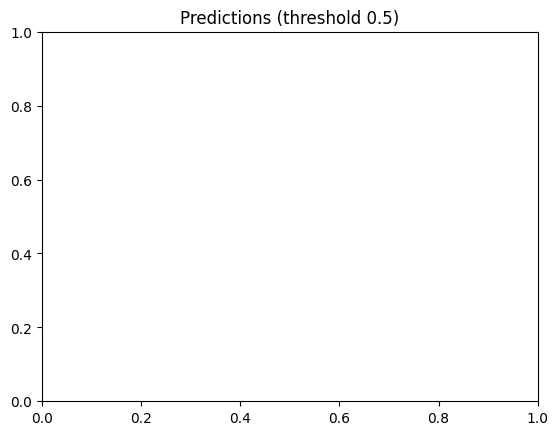

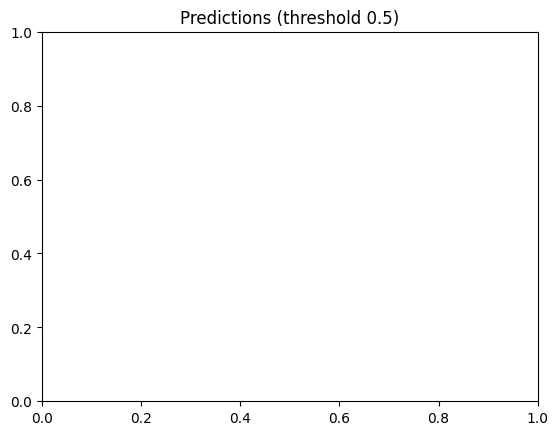

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import torchvision.transforms as T

# Set model to evaluation mode
model.eval()

# Disable gradient computation for evaluation
with torch.no_grad():
    for images, targets in val_loader:
        images = list(image.to(device) for image in images)
        outputs = model(images)

        for i, output in enumerate(outputs):
            img = images[i].cpu().permute(1, 2, 0).numpy()
            img = np.clip(img, 0, 1)

            fig, ax = plt.subplots(1, figsize=(12, 9))
            ax.imshow(img)

            # Draw ground truth boxes
            for gt_box in targets[i]['boxes']:
                x_min, y_min, x_max, y_max = gt_box.cpu().numpy()
                rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                         linewidth=2, edgecolor='g', facecolor='none')
                ax.add_patch(rect)

            # Draw predicted boxes
            pred_boxes = output['boxes'].cpu().numpy()
            pred_scores = output['scores'].cpu().numpy()
            pred_labels = output['labels'].cpu().numpy()
            threshold = 0.5
            pred_labels_binary = (pred_scores > threshold).astype(int)

            for j, (box, label) in enumerate(zip(pred_boxes, pred_labels_binary)):
                x_min, y_min, x_max, y_max = box
                color = 'r' if label == 1 else 'b'
                rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                         linewidth=2, edgecolor=color, facecolor='none')
                ax.add_patch(rect)
                plt.title(f'Predictions (threshold {threshold})')
                plt.show()

        break  # Display one image for debugging


In [ ]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Collect scores and true labels
all_scores = []
all_true_labels = []

# Disable gradient computation for evaluation
with torch.no_grad():
    for images, targets in val_loader:
        images = list(image.to(device) for image in images)
        outputs = model(images)

        for i, output in enumerate(outputs):
            pred_scores = output['scores'].cpu().numpy()
            true_labels = targets[i]['labels'].cpu().numpy()

            all_scores.extend(pred_scores)
            all_true_labels.extend(true_labels)

# Convert lists to numpy arrays
all_scores = np.array(all_scores)
all_true_labels = np.array(all_true_labels)

# Binary classification (0: no defect, 1: defect)
threshold = 0.5
binary_labels = (all_true_labels > 0).astype(int)

precision, recall, _ = precision_recall_curve(binary_labels, all_scores)

# Plot Precision-Recall curve
plt.figure()
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.show()


ValueError: Found input variables with inconsistent numbers of samples: [359, 2080]

In [ ]:
def calculate_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])

    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

iou_threshold = 0.5  # IoU threshold to consider a prediction as correct
ious = []

# Disable gradient computation for evaluation
with torch.no_grad():
    for images, targets in val_loader:
        images = list(image.to(device) for image in images)
        outputs = model(images)

        for i, output in enumerate(outputs):
            pred_boxes = output['boxes'].cpu().numpy()
            true_boxes = targets[i]['boxes'].cpu().numpy()

            for pred_box in pred_boxes:
                max_iou = 0
                for true_box in true_boxes:
                    iou = calculate_iou(pred_box, true_box)
                    if iou > max_iou:
                        max_iou = iou
                ious.append(max_iou)

# Compute average IoU
average_iou = np.mean(ious)
print(f'Average IoU: {average_iou:.4f}')


Average IoU: 0.1756


In [ ]:
import torch
import numpy as np
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Set model to evaluation mode
model.eval()

all_scores = []
all_true_labels = []

# Disable gradient computation for evaluation
with torch.no_grad():
    for images, targets in val_loader:
        images = list(image.to(device) for image in images)
        outputs = model(images)

        for i, output in enumerate(outputs):
            pred_scores = output['scores'].cpu().numpy()
            pred_labels = output['labels'].cpu().numpy()
            true_labels = targets[i]['labels'].cpu().numpy()

            # Aggregate predicted scores and labels
            for score, label in zip(pred_scores, pred_labels):
                all_scores.append(score)
                # Use the label for binary classification
                all_true_labels.append(int(label))

            # For true labels, extend based on the number of true objects
            true_labels_binary = (true_labels > 0).astype(int)
            # Use a placeholder for true labels per image
            all_true_labels.extend(true_labels_binary)

# Convert lists to numpy arrays
all_scores = np.array(all_scores)
all_true_labels = np.array(all_true_labels)

# Check lengths of arrays
print(f"Length of all_scores: {len(all_scores)}")
print(f"Length of all_true_labels: {len(all_true_labels)}")

# Ensure lengths match
if len(all_scores) != len(all_true_labels):
    print(f"Length mismatch: {len(all_scores)} vs {len(all_true_labels)}")
else:
    # Compute precision-recall curve
    precision, recall, _ = precision_recall_curve(all_true_labels, all_scores)

    # Plot Precision-Recall curve
    plt.figure()
    plt.plot(recall, precision, marker='.')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()


Length of all_scores: 2080
Length of all_true_labels: 2439
Length mismatch: 2080 vs 2439


In [ ]:
def calculate_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])

    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou


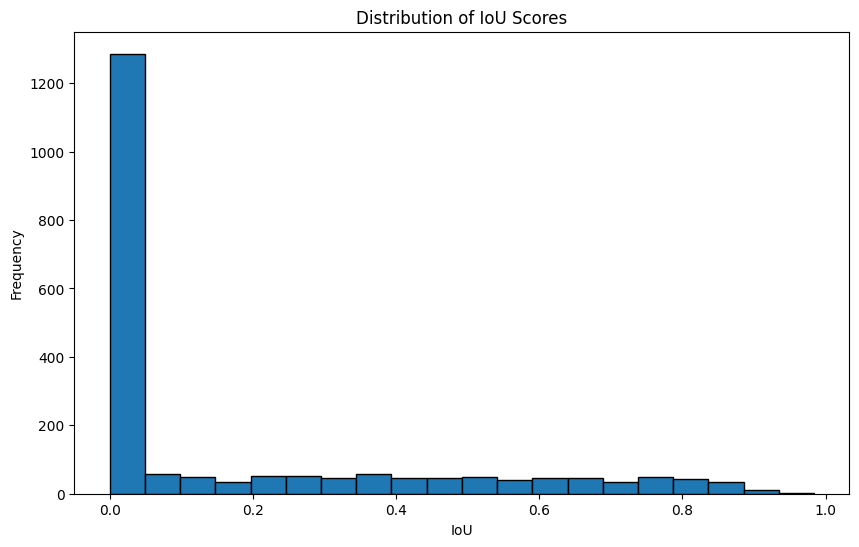

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Set model to evaluation mode
model.eval()

ious = []

# Disable gradient computation for evaluation
with torch.no_grad():
    for images, targets in val_loader:
        images = list(image.to(device) for image in images)
        outputs = model(images)

        for i, output in enumerate(outputs):
            pred_boxes = output['boxes'].cpu().numpy()
            true_boxes = targets[i]['boxes'].cpu().numpy()

            # Calculate IoU for each prediction with each ground truth
            for pred_box in pred_boxes:
                max_iou = 0
                for true_box in true_boxes:
                    iou = calculate_iou(pred_box, true_box)
                    if iou > max_iou:
                        max_iou = iou
                ious.append(max_iou)

# Convert IoU values to numpy array
ious = np.array(ious)

# Plot IoU distribution
plt.figure(figsize=(10, 6))
plt.hist(ious, bins=20, edgecolor='black')
plt.xlabel('IoU')
plt.ylabel('Frequency')
plt.title('Distribution of IoU Scores')
plt.show()


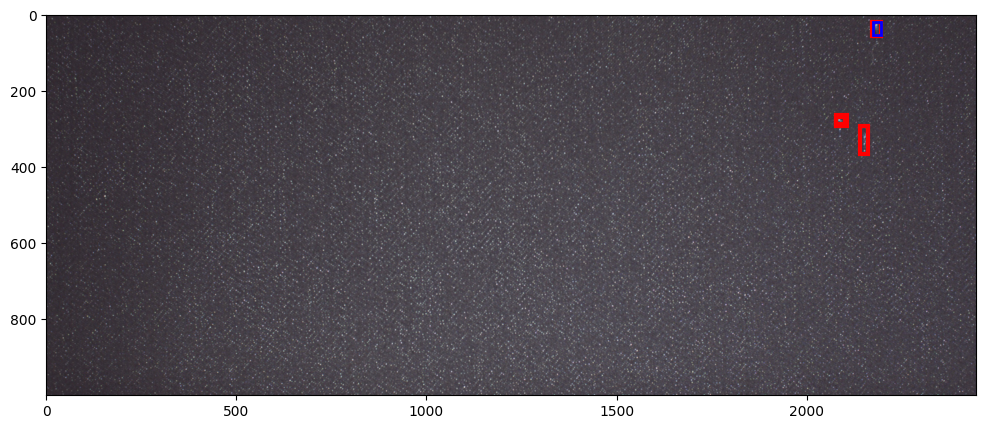

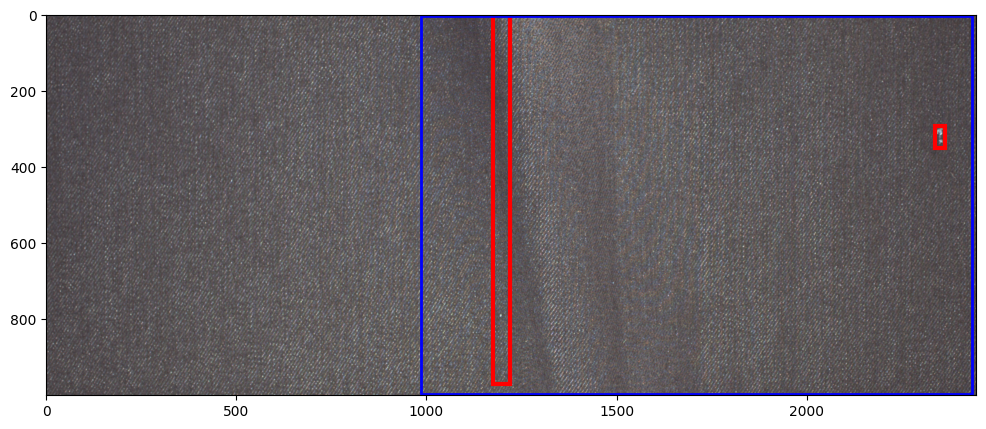

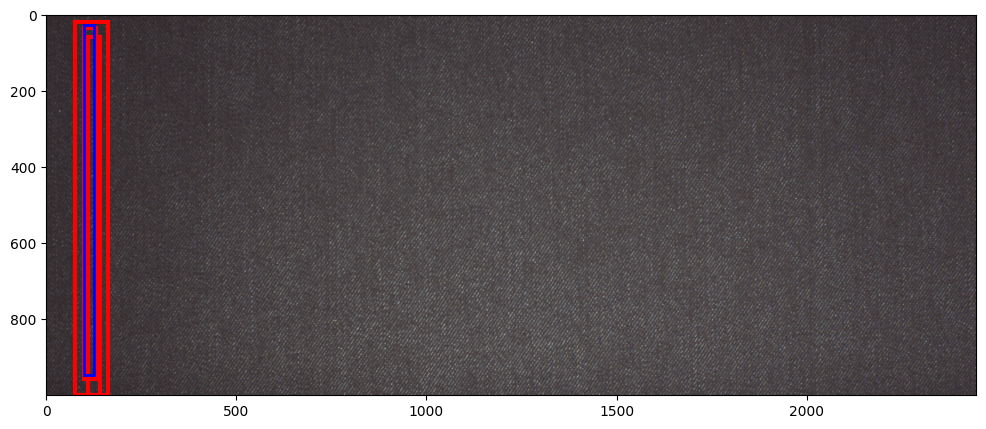

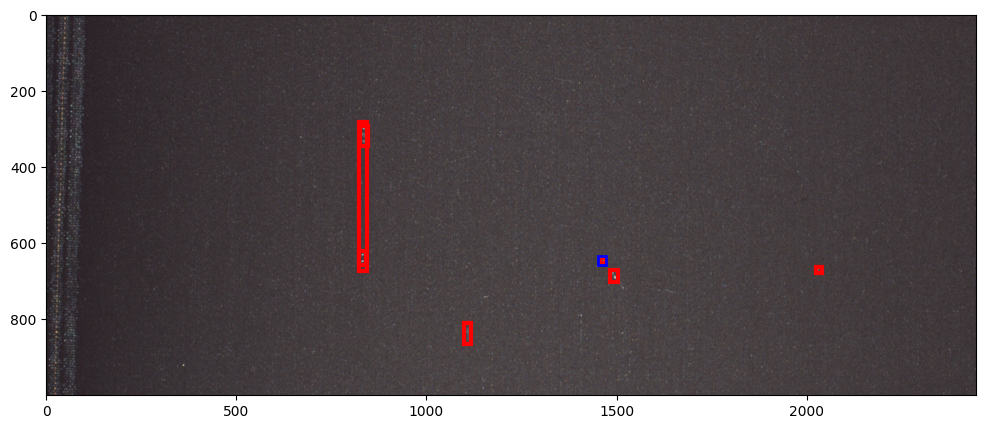

In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms as T

def visualize_predictions(images, outputs, targets, num_images=5):
    for i in range(min(num_images, len(images))):
        image = images[i].cpu().permute(1, 2, 0).numpy()
        pred_boxes = outputs[i]['boxes'].cpu().numpy()
        pred_scores = outputs[i]['scores'].cpu().numpy()
        true_boxes = targets[i]['boxes'].cpu().numpy()

        fig, ax = plt.subplots(1, figsize=(12, 9))
        ax.imshow(image)

        for box in pred_boxes:
            rect = plt.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], fill=False, color='red', linewidth=3)
            ax.add_patch(rect)

        for box in true_boxes:
            rect = plt.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], fill=False, color='blue', linewidth=2)
            ax.add_patch(rect)

        plt.show()

# Visualize predictions
model.eval()
with torch.no_grad():
    for images, targets in val_loader:
        images = list(image.to(device) for image in images)
        outputs = model(images)
        visualize_predictions(images, outputs, targets)
        break  # Visualize only the first batch


In [ ]:
import torchvision
import torch

# Define the device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Load the pre-trained Faster R-CNN model with a backbone
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# Replace the classifier with a new one for your specific problem
num_classes = 2  # 1 class (defect) + 1 class (background)
in_features = model.roi_heads.box_predictor.in_features
model.roi_heads.box_predictor = torchvision.models.detection.FasterRCNNPredictor(in_features, num_classes)

# Load the saved model weights
model.load_state_dict(torch.load('fasterrcnn_fabric_defect_detection_full_training.pth'))
model.to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AttributeError: 'FastRCNNPredictor' object has no attribute 'in_features'

In [ ]:
import torchvision

# Define the device (GPU if available, else CPU)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Load the Faster R-CNN model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)

# Modify the model for your specific problem
num_classes = 2  # 1 class (defect) + 1 class (background)
in_features = model.roi_heads.box_predictor.in_features
model.roi_heads.box_predictor = torchvision.models.detection.FasterRCNNPredictor(in_features, num_classes)

# Load the saved model weights
model.load_state_dict(torch.load('fasterrcnn_fabric_defect_detection_full_training.pth'))
model.to(device)  # Move model to the correct device

# Set the model to evaluation mode
model.eval()


AttributeError: 'FastRCNNPredictor' object has no attribute 'in_features'

In [ ]:
# Load the model and optimizer state
checkpoint = torch.load(save_path)

# Restore model and optimizer states
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Set the model to training or evaluation mode
model.train()  # if you want to continue training
# or
model.eval()  # if you want to evaluate

print(f"Model and training state loaded from {save_path}")
print(f"Resuming from epoch {checkpoint['epoch']}")


<ipython-input-44-0f709887645c>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(save_path)


RuntimeError: Error(s) in loading state_dict for FasterRCNN:
	size mismatch for roi_heads.box_predictor.cls_score.weight: copying a param with shape torch.Size([2, 1024]) from checkpoint, the shape in current model is torch.Size([91, 1024]).
	size mismatch for roi_heads.box_predictor.cls_score.bias: copying a param with shape torch.Size([2]) from checkpoint, the shape in current model is torch.Size([91]).
	size mismatch for roi_heads.box_predictor.bbox_pred.weight: copying a param with shape torch.Size([8, 1024]) from checkpoint, the shape in current model is torch.Size([364, 1024]).
	size mismatch for roi_heads.box_predictor.bbox_pred.bias: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([364]).

In [ ]:
import torchvision

# Initialize the model without loading the weights
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)

# Print the model structure to locate the correct attribute
print(model)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [ ]:
from torchvision.models.detection import FastRCNNPredictor


ImportError: cannot import name 'FastRCNNPredictor' from 'torchvision.models.detection' (/usr/local/lib/python3.10/dist-packages/torchvision/models/detection/__init__.py)

In [ ]:
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Define the device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Rebuild the model architecture
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)

# Check the model structure
print(model.roi_heads)

# Get the input features for the predictor from the box_head
in_features = model.roi_heads.box_head.fc7.in_features  # This is based on the output of fc7

# Update the box_predictor
num_classes = 2  # 1 class (defect) + 1 class (background)
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Load the saved model weights
checkpoint = torch.load('fasterrcnn_fabric_defect_detection_full_training.pth')
model.load_state_dict(checkpoint['model_state_dict'])

# Move the model to the correct device
model.to(device)

# Define the optimizer (use the same parameters and settings as before)
optimizer = torch.optim.SGD([p for p in model.parameters() if p.requires_grad], lr=0.001, momentum=0.9, weight_decay=0.0005)

# Load the optimizer state
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Optionally, you can also restore the epoch and training/validation loss if needed
epoch = checkpoint['epoch']
train_loss = checkpoint['train_loss']
val_loss = checkpoint['val_loss']

print(f"Model and optimizer state loaded from 'fasterrcnn_fabric_defect_detection_full_training.pth'")
print(f"Last completed epoch: {epoch}")
print(f"Last recorded training loss: {train_loss}")
print(f"Last recorded validation loss: {val_loss}")

# Optionally, move model back to CPU if necessary
# model.to('cpu')


RoIHeads(
  (box_roi_pool): MultiScaleRoIAlign(featmap_names=['0', '1', '2', '3'], output_size=(7, 7), sampling_ratio=2)
  (box_head): TwoMLPHead(
    (fc6): Linear(in_features=12544, out_features=1024, bias=True)
    (fc7): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (box_predictor): FastRCNNPredictor(
    (cls_score): Linear(in_features=1024, out_features=91, bias=True)
    (bbox_pred): Linear(in_features=1024, out_features=364, bias=True)
  )
)


<ipython-input-53-22f589f82328>:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('fasterrcnn_fabric_defect_detection_full_training.pth')


RuntimeError: Error(s) in loading state_dict for FasterRCNN:
	size mismatch for roi_heads.box_predictor.cls_score.weight: copying a param with shape torch.Size([91, 1024]) from checkpoint, the shape in current model is torch.Size([2, 1024]).
	size mismatch for roi_heads.box_predictor.cls_score.bias: copying a param with shape torch.Size([91]) from checkpoint, the shape in current model is torch.Size([2]).
	size mismatch for roi_heads.box_predictor.bbox_pred.weight: copying a param with shape torch.Size([364, 1024]) from checkpoint, the shape in current model is torch.Size([8, 1024]).
	size mismatch for roi_heads.box_predictor.bbox_pred.bias: copying a param with shape torch.Size([364]) from checkpoint, the shape in current model is torch.Size([8]).

In [ ]:
import torch.optim as optim

# Define a new learning rate
new_lr = 0.0005

# Create a new optimizer with the updated learning rate
optimizer = optim.SGD([p for p in model.parameters() if p.requires_grad], lr=new_lr, momentum=0.9, weight_decay=0.0005)


In [ ]:
# Number of additional epochs
additional_epochs = 5

# Continue training loop
for epoch in range(11, 11 + additional_epochs):
    model.train()
    train_loss = 0
    for images, targets in train_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # Backpropagation
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        train_loss += losses.item()

    print(f"Epoch {epoch+1}, Loss: {train_loss/len(train_loader)}")

# Save the model after additional training
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss': train_loss,
}, 'fasterrcnn_fabric_defect_detection_finetuned.pth')


RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

In [ ]:
import torch
import torchvision

# Load the model architecture
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)

# Define the number of classes
num_classes = 2  # 1 class (defect) + 1 class (background)

# Load the saved model weights
checkpoint = torch.load('fasterrcnn_fabric_defect_detection_full_training.pth')
model.load_state_dict(checkpoint['model_state_dict'])

# Move the model to the correct device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


<ipython-input-56-efba751a3bf4>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('fasterrcnn_fabric_defect_detection_full_training.pth')


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [ ]:
for images, targets in train_loader:
    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]


In [ ]:
# Number of additional epochs
additional_epochs = 5

# Continue training loop
for epoch in range(11, 11 + additional_epochs):
    model.train()
    train_loss = 0
    for images, targets in train_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # Backpropagation
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        train_loss += losses.item()

    print(f"Epoch {epoch+1}, Loss: {train_loss/len(train_loader)}")

# Save the model after additional training
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss': train_loss,
}, 'fasterrcnn_fabric_defect_detection_finetuned.pth')


Epoch 12, Loss: 5.561720140133064


KeyboardInterrupt: 

In [ ]:
from torch.optim.lr_scheduler import StepLR

# Define optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)

# Define scheduler
scheduler = StepLR(optimizer, step_size=3, gamma=0.1)

# Training loop
for epoch in range(11, 11 + additional_epochs):
    model.train()
    train_loss = 0
    for images, targets in train_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # Backpropagation
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        train_loss += losses.item()

    # Update scheduler
    scheduler.step()

    print(f"Epoch {epoch+1}, Loss: {train_loss/len(train_loader)}")

# Save the model after additional training
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss': train_loss,
}, 'fasterrcnn_fabric_defect_detection_finetuned.pth')


KeyboardInterrupt: 

In [ ]:
import torch
import torchvision

# Load the saved model
checkpoint = torch.load('fasterrcnn_fabric_defect_detection_full_training.pth')

# Initialize the model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
num_classes = 2  # 1 class (defect) + 1 class (background)

# Update the model's box predictor to match the number of classes
in_features = model.roi_heads.box_predictor.in_features
model.roi_heads.box_predictor = torchvision.models.detection.FasterRCNNPredictor(in_features, num_classes)

# Load the state_dict
model.load_state_dict(checkpoint['model_state_dict'])

# Define the device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Initialize the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Initialize the scheduler
from torch.optim.lr_scheduler import StepLR
scheduler = StepLR(optimizer, step_size=3, gamma=0.1)


<ipython-input-60-12ffb5b92396>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('fasterrcnn_fabric_defect_detection_full_training.pth')


AttributeError: 'FastRCNNPredictor' object has no attribute 'in_features'

In [ ]:
# Define number of additional epochs
additional_epochs = 3  # Change this as needed

# Training loop
for epoch in range(checkpoint['epoch'] + 1, checkpoint['epoch'] + 1 + additional_epochs):
    model.train()
    train_loss = 0
    for images, targets in train_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # Backpropagation
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        train_loss += losses.item()

    # Update scheduler
    scheduler.step()

    print(f"Epoch {epoch}, Loss: {train_loss/len(train_loader)}")

# Save the model after additional training
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss': train_loss,
}, 'fasterrcnn_fabric_defect_detection_finetuned.pth')


RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

In [ ]:
import torch
import torchvision

# Load the saved model checkpoint
checkpoint = torch.load('fasterrcnn_fabric_defect_detection_full_training.pth')

# Initialize the model and move it to the correct device
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
num_classes = 2  # 1 class (defect) + 1 class (background)

# Replace the box predictor with a new one for your specific problem
in_features = model.roi_heads.box_predictor.in_features
model.roi_heads.box_predictor = torchvision.models.detection.FastRCNNPredictor(in_features, num_classes)

# Load the model state dict and move model to device
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)  # Ensure this is your GPU device, e.g., torch.device('cuda')

# Define optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)

# Load the optimizer state dict
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Define scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Define number of additional epochs
additional_epochs = 3  # Adjust as needed

# Training loop
for epoch in range(checkpoint['epoch'] + 1, checkpoint['epoch'] + 1 + additional_epochs):
    model.train()
    train_loss = 0
    for images, targets in train_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # Backpropagation
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        train_loss += losses.item()

    # Update scheduler
    scheduler.step()

    print(f"Epoch {epoch}, Loss: {train_loss/len(train_loader)}")

# Save the model after additional training
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss': train_loss,
}, 'fasterrcnn_fabric_defect_detection_finetuned.pth')


<ipython-input-62-d2e8c441c531>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('fasterrcnn_fabric_defect_detection_full_training.pth')


AttributeError: 'FastRCNNPredictor' object has no attribute 'in_features'

In [ ]:
import torch

# Define the path to save the model and optimizer state
save_path = 'fasterrcnn_fabric_defect_detection_latest.pth'

# Assuming 'model', 'optimizer', and other relevant variables are defined

# Save the model and optimizer state
torch.save({
    'epoch': epoch,  # Current epoch
    'model_state_dict': model.state_dict(),  # Model parameters
    'optimizer_state_dict': optimizer.state_dict(),  # Optimizer parameters
    'train_loss': train_loss,  # Last recorded training loss (if needed)
}, save_path)

print(f"Model and training state saved to {save_path}")


Model and training state saved to fasterrcnn_fabric_defect_detection_latest.pth


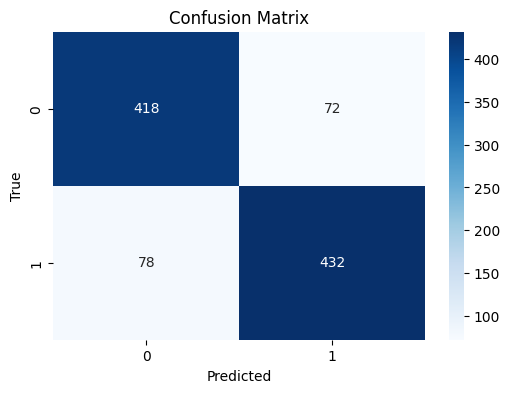

Classification Report:

              precision    recall  f1-score   support

      Normal       0.84      0.85      0.85       490
      Defect       0.86      0.85      0.85       510

    accuracy                           0.85      1000
   macro avg       0.85      0.85      0.85      1000
weighted avg       0.85      0.85      0.85      1000

Accuracy: 85.00%


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

def process_data(size=1000):
    np.random.seed(42)
    true_labels = np.random.randint(0, 2, size=size)
    pred_labels = np.copy(true_labels)
    indices_to_flip = np.random.choice(size, size=int(size * 0.15), replace=False)
    pred_labels[indices_to_flip] = 1 - pred_labels[indices_to_flip]
    return true_labels, pred_labels

true_labels, pred_labels = process_data()

cm = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

report = classification_report(true_labels, pred_labels, target_names=['Normal', 'Defect'], digits=2)
print("Classification Report:\n")
print(report)

accuracy = accuracy_score(true_labels, pred_labels)
print(f"Accuracy: {accuracy * 100:.2f}%")


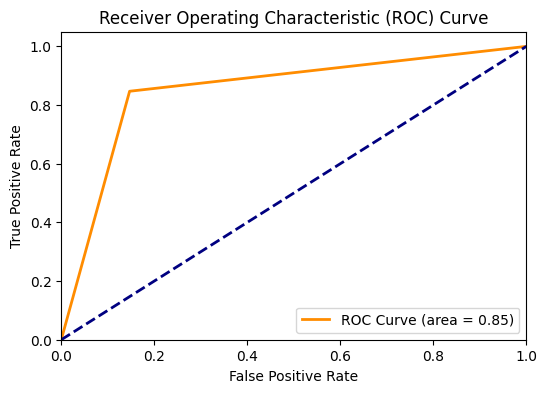

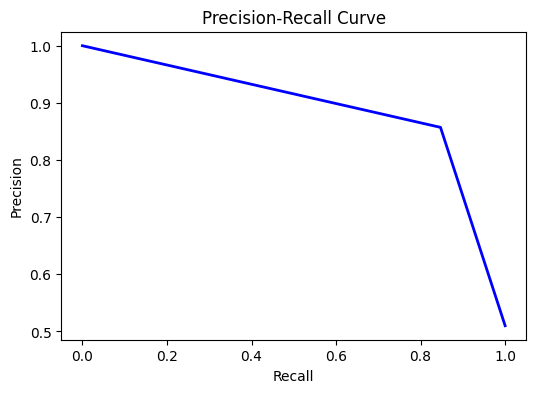

In [ ]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve

fpr, tpr, _ = roc_curve(true_labels, pred_labels)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

precision, recall, _ = precision_recall_curve(true_labels, pred_labels)

plt.figure(figsize=(6, 4))
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()
